In [3]:
import sys
sys.path.insert(0, '../')

# module imports
import pandas as pd
import numpy
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from collections import Counter
from itertools import chain
import ast
import random
from datetime import datetime
from importlib import reload

# local imports
from fit_model import fit
import BERT
import build_dataset
import baseline
import fit_model

# reload modules
reload(BERT)
reload(build_dataset)
reload(baseline)
reload(fit_model)


# For reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Load the data

genereate synthetic data

In [336]:
# from build_synthetic_data_frames import constant_loc_distinct, random_loc_distinct, ten_sequence_loc_constant, weekly_location_cycle
# # Generate synthetic data for 100 users over 10 days
# df = weekly_location_cycle(100, 100, 100)
# # group by user and sort by date
# df.sort_values(by=['user', 'date']).head(30)

or use the real data

In [337]:
# load data from csv
DATASET_PATH = "../../data/final_data_500.csv"
df = pd.read_csv(DATASET_PATH)

In [338]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm

BATCH_SIZE = 8 
num_workers = 4

# Function for setting seed (assuming it's defined)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# split data into train, val, test
train_df, val_df, test_df = build_dataset.stratified_user_week_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, ensure_user_in_all_sets=True)

# compute ranks for each user based on the train set
rank_dict = build_dataset.compute_rank_dict(train_df)

# create vocabulary based on the whole dataset
dataset = build_dataset.BertMobilityDataset(df,rank_dict)
vocab = dataset.vocab 

# Initialize the datasets with the rank dictionary and vocabulary
train_dataset = build_dataset.BertMobilityDataset(train_df,rank_dict, vocab)
val_dataset = build_dataset.BertMobilityDataset(val_df, rank_dict, vocab)
test_dataset = build_dataset.BertMobilityDataset(test_df, rank_dict, vocab)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)

In [339]:
# check dataset stats
print(train_dataset.calculate_max_sequence_length(), val_dataset.calculate_max_sequence_length(), test_dataset.calculate_max_sequence_length())
print(len(train_df), len(val_df), len(test_df))
print(train_dataset.calculate_avg_sequence_length(), val_dataset.calculate_avg_sequence_length(), test_dataset.calculate_avg_sequence_length())

219 175 179
207337 44430 44430
27.34955810579079 27.64779091474798 27.025547445255473


In [340]:
train_dataset[0]

{'y': tensor([   1,   17,   54,   43,   54,   17,   54,   17,   43,   17,   54,   17,
          456,   17,   43,   17,   54,   43,   54, 4887,   17,   54,   17,   43,
           54,   17,   54,   43,   54,   62,   43,   17,   43,    4,   17,   43,
           17,   43,   17,   43,   17, 8088,   17,   43,   17,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   

## Train the model

In [341]:
import copy
import BERT  # Assuming BERT is a module you've defined

def make_model(ntokens_location, ntokens_user, vocab_sizes, emb_sizes, use_fusion_embeddings=False,
               n_layers=6, d_model=512, d_ff=2048, n_heads=8, dropout=0.1):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy
    attn = BERT.MultiHeadedAttention(n_heads, d_model)
    ff = BERT.PositionwiseFeedForward(d_model, d_ff, dropout)
    position = BERT.PositionalEncoding(d_model, dropout)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Choose the embedding layer based on the flag
    if use_fusion_embeddings:
        src_embed = nn.Sequential(BERT.ModifiedFusionEmbeddings(d_model, ntokens_location, ntokens_user, vocab_sizes, emb_sizes, device), c(position))
    else:
        src_embed = nn.Sequential(BERT.ModifiedEmbeddings(d_model, ntokens_location, ntokens_user), c(position))

    model = BERT.BERT_model(
        BERT.Encoder(BERT.EncoderLayer(d_model, c(attn), c(ff), dropout), n_layers),
        src_embed,
        d_model, ntokens_location
    )
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)  # Note the underscore for in-place operation
    return model


In [342]:
# Import necessary libraries
import torch
import torch.nn as nn
import baseline  
import BERT  
import fit_model  

# Set device based on CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset and vocabulary parameters
vocab = train_dataset.vocab
max_rank = dataset.df['rank'].max()
ntokens_user = train_dataset.users.astype(int).max() + 1  # len(train_dataset.users) + 4 todo: change user labels according to max user id + 4 special tkoens
ntokens_location = len(vocab)
print('ntokens_user:', ntokens_user)
print('ntokens_location:', ntokens_location)

# Model hyperparameters
epochs = 100 
d_model = 32
vocab_sizes = [ntokens_location]  # Additional feature vocab sizes [ntokens_location, max_rank+1,8,25]
emb_sizes = [d_model]          # Additional feature embedding sizes
d_hid = 32  
nlayers = 1  
nhead = 2  
dropout = 0  
lr = 0.001  
use_fusion_embeddings = False  

# Model initialization
print("\nInitializing model with the following parameters:")
print(f"  Epochs: {epochs}")
print(f"  d_model: {d_model}")
print(f"  vocab_sizes: {vocab_sizes}")
print(f"  emb_sizes: {emb_sizes}")
print(f"  d_hid (d_ff): {d_hid}")
print(f"  nlayers: {nlayers}")
print(f"  nhead: {nhead}")
print(f"  Dropout: {dropout}")
print(f"  Learning Rate: {lr}")
print(f"  Use Fusion Embeddings: {use_fusion_embeddings}")

model = make_model(ntokens_location=ntokens_location,
                   ntokens_user=ntokens_user,
                   vocab_sizes=vocab_sizes,
                   emb_sizes=emb_sizes,
                   use_fusion_embeddings=use_fusion_embeddings,
                   n_layers=nlayers,
                   d_model=d_model,
                   d_ff=d_hid,
                   n_heads=nhead,
                   dropout=dropout)

# Get user-defined variant string
variant = input("Enter a variant string: ")
print(f"Training name: {variant}")

# Initialize baseline model
bl_simple = baseline.BaselineModel(train_dataset, ntokens_location)
bl_sampled = baseline.BaselineModelSampled(train_dataset, ntokens_location)
bl_markov_1 = baseline.BaselineModelMarkov1(train_dataset, ntokens_location)


# GPU setup for multi-GPU environments
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# Move model to the specified device
model.to(device)

# Optimizer setup
opt = torch.optim.Adam(model.parameters(), lr=lr) #  removed betas=(0.9, 0.98)
# opt = NoamOpt(d_hid, 1, 4000, torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Model training and evaluation
print("\nStarting training and evaluation...")
measures_train = fit_model.fit(model, opt, train_loader, val_loader, epochs, ntokens_location, bl_simple, bl_sampled, bl_markov_1, use_fusion_embeddings)

# Unpack training and validation measures
train_loss_list, train_accuracy_list, validation_loss_list, val_accuracy_list, val_baseline_simple_accuracy_list, val_baseline_sampled_accuracy_list, val_baseline_markov_1_accuracy_list = measures_train

Using device: cpu
ntokens_user: 829
ntokens_location: 14037

Initializing model with the following parameters:
  Epochs: 100
  d_model: 32
  vocab_sizes: [14037]
  emb_sizes: [32]
  d_hid (d_ff): 32
  nlayers: 1
  nhead: 2
  Dropout: 0
  Learning Rate: 0.001
  Use Fusion Embeddings: False
Training name: bert_0_500


# Save results


In [ ]:
variant

'bert_0_500'

In [ ]:
torch.save(model, f"../saved_models/{variant}.pt")

In [ ]:
test_model = torch.load(f"../saved_models/{variant}.pt")

In [ ]:
import evaluate_model
reload(evaluate_model)

# Save model configuration
model_config = {
    'ntokens': int(ntokens_location),
    'epochs': epochs,
    'd_model': d_model,
    'd_hid': d_hid,
    'nlayers': nlayers,
    'nhead': nhead,
    'dropout': dropout,
    'lr': lr,
    'device': device.type
}
evaluate_model.save_model_data( measures_train, model_config, variant)

Saved measures to ../../output/training_measures_bert_0_50.json, and config to ../../output/model_config_bert_0_50.json


In [4]:
# load model data
variant = input("Enter the variant string: ")
from evaluate_model import load_model_data

measures, config = load_model_data(model, variant)

# # extract data from the JSON
measures_tuple = tuple(measures[key] for key in sorted(measures.keys()))
baseline_loss_list, train_accuracy_list, train_loss_list, val_accuracy_list, val_baseline_accuracy_list, validation_loss_list  = measures_tuple


NameError: name 'model' is not defined

In [ ]:
# compute the average validation accuracy for the last 100 epochs
print('average validation accuracy for the last 20 epochs', np.mean(val_accuracy_list[-20:])) 

average validation accuracy for the last 20 epochs 0.46885055


# Plot results
todo: refactor plot code 

In [4]:
# load model data
from evaluate_model import load_model_data

variant = "bert_0"
measures = load_model_data(variant)

# extract measures
train_loss_list = measures[0]["train_loss_list"]
validation_loss_list = measures[0]["validation_loss_list"]
train_accuracy_list = measures[0]["train_accuracy_list"]
val_accuracy_list = measures[0]["val_accuracy_list"]
# val_baseline_accuracy_list = measures[0]["val_baseline_accuracy_list"]
val_baseline_simple_accuracy_list = measures[0]["val_baseline_simple_accuracy_list"]
val_baseline_sampled_accuracy_list  = measures[0]["val_baseline_sampled_accuracy_list"]
val_baseline_markov_1_accuracy_list = measures[0]["val_baseline_markov_1_accuracy_list"]
ntokens = measures[1]["ntokens"]
epochs = measures[1]["epochs"]
d_model = measures[1]["d_model"]
d_hid = measures[1]["d_hid"]
nlayers = measures[1]["nlayers"]
nhead = measures[1]["nhead"]
dropout = measures[1]["dropout"]
lr  = measures[1]["lr"]

/home/s212588/model/notebooks


In [5]:
fig_name =  variant + '.png'

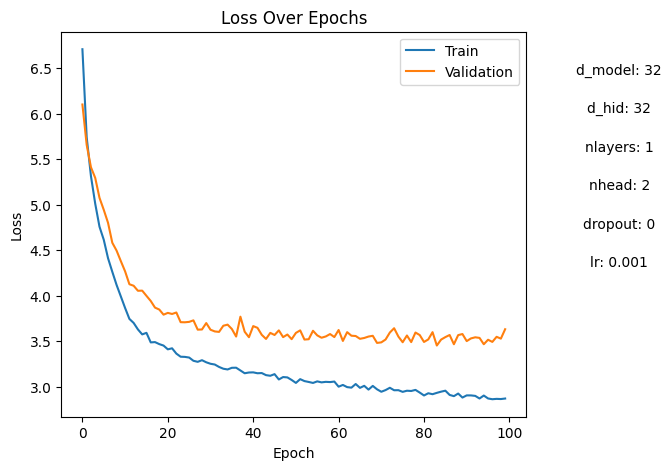

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming train_loss_list and validation_loss_list are defined elsewhere in your code
# Convert lists to pandas Series
train_loss_series = pd.Series(train_loss_list)
validation_loss_series = pd.Series(validation_loss_list)

# Calculate rolling average with a chosen window size, e.g., window=5 for a 5-point moving average
rolling_window_size = 5
train_rolling_average = train_loss_series.rolling(window=rolling_window_size).mean()
validation_rolling_average = validation_loss_series.rolling(window=rolling_window_size).mean()

# Create a figure and axis object
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

# Plot the rolling averages as solid lines
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='Train', linestyle='-')
plt.plot(np.arange(len(validation_loss_list)), validation_loss_list, label='Validation', linestyle='-')

plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Your existing text annotations
# Assuming fig_name, d_model, d_hid, nlayers, nhead, dropout, lr are defined elsewhere
# plt.text(1.4, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('../../figures/loss_' + fig_name, dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

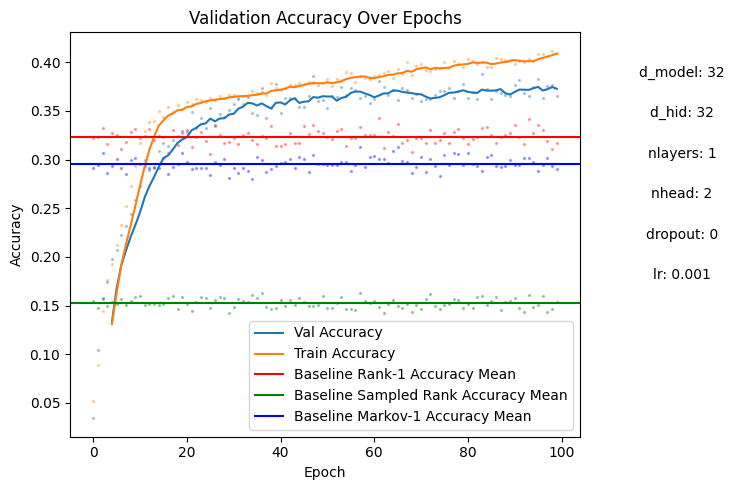

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming the accuracy lists are defined elsewhere in your code
# Convert lists to pandas Series for easier rolling window calculation
val_accuracy_series = pd.Series(val_accuracy_list)
val_baseline_simple_accuracy_series = pd.Series(val_baseline_simple_accuracy_list)
val_baseline_sampled_accuracy_series = pd.Series(val_baseline_sampled_accuracy_list)
val_baseline_markov_1_accuracy_series = pd.Series(val_baseline_markov_1_accuracy_list)
train_accuracy_series = pd.Series(train_accuracy_list)

# Calculate rolling average with a chosen window size, e.g., window=5 for a 5-point moving average
rolling_window_size = 5
val_accuracy_rolling = val_accuracy_series.rolling(window=rolling_window_size).mean()
train_accuracy_rolling = train_accuracy_series.rolling(window=rolling_window_size).mean()

# Calculate mean accuracy for each baseline to plot as constant lines
val_baseline_simple_accuracy_mean = val_baseline_simple_accuracy_series.mean()
val_baseline_sampled_accuracy_mean = val_baseline_sampled_accuracy_series.mean()
val_baseline_markov_1_accuracy_mean = val_baseline_markov_1_accuracy_series.mean()

# Create a figure and axis object
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

# Scatter plot for the original data points with decreased size
# Use label='_nolegend_' to exclude scatter plots from the legend
scatter_size = 2  # Decrease scatter point size for better visibility
plt.scatter(np.arange(len(val_accuracy_list)), val_accuracy_list, alpha=0.3, s=scatter_size, label='_nolegend_')
plt.scatter(np.arange(len(train_accuracy_list)), train_accuracy_list, alpha=0.3, s=scatter_size, label='_nolegend_')
plt.scatter(np.arange(len(val_baseline_simple_accuracy_list)), val_baseline_simple_accuracy_list, alpha=0.3, s=scatter_size,color='r', label='_nolegend_')
plt.scatter(np.arange(len(val_baseline_sampled_accuracy_list)), val_baseline_sampled_accuracy_list, alpha=0.3, s=scatter_size, color='g',label='_nolegend_')
plt.scatter(np.arange(len(val_baseline_markov_1_accuracy_list)), val_baseline_markov_1_accuracy_list, alpha=0.3, s=scatter_size,color='b', label='_nolegend_')

# Plot the rolling averages as solid lines with labels for legend
plt.plot(np.arange(len(val_accuracy_list)), val_accuracy_rolling, label='Val Accuracy ')
plt.plot(np.arange(len(train_accuracy_list)), train_accuracy_rolling, label='Train Accuracy ')

# Plot baseline accuracies as constant horizontal lines
plt.axhline(y=val_baseline_simple_accuracy_mean, color='r', linestyle='-', label='Baseline Rank-1 Accuracy Mean')
plt.axhline(y=val_baseline_sampled_accuracy_mean, color='g', linestyle='-', label='Baseline Sampled Rank Accuracy Mean')
plt.axhline(y=val_baseline_markov_1_accuracy_mean, color='b', linestyle='-', label='Baseline Markov-1 Accuracy Mean')

plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Move the legend outside of the plot
ax.legend(loc='lower right')

# Adjust layout to make room for the legend
plt.tight_layout()

# Your existing text annotations
plt.text(1.2, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('../../figures/accuracy_' + fig_name, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
